In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2],
    c2 = [0.5, 2],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = None,
    mask = True))

see one see two 2 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c2 = np.max([model.optimizer.C2[1] - ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[0]])
    model.optimizer.c1 = np.min([model.optimizer.C1[0] + ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 100, Accuracy: 0.9444444444444444, Loss: 0.19383557637532553
Checkpoint 200, Accuracy: 0.9691358024691358, Loss: 0.11876266090958207
Checkpoint 300, Accuracy: 0.9629629629629629, Loss: 0.10676155266938386
Checkpoint 400, Accuracy: 0.9691358024691358, Loss: 0.11473395206310132
Checkpoint 500, Accuracy: 0.9691358024691358, Loss: 0.11251286224082664


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.99790835 0.00107928 0.00101233]
[1. 0. 0.] <-> [0.9977476  0.00106175 0.00119063]
[1. 0. 0.] <-> [9.9805498e-01 1.1396628e-03 8.0533570e-04]
[0. 0. 1.] <-> [9.9967262e-03 1.0407012e-04 9.8989922e-01]
[1. 0. 0.] <-> [9.9493426e-01 4.4253133e-03 6.4052053e-04]
[1. 0. 0.] <-> [0.9953811  0.00128025 0.00333867]
[0. 0. 1.] <-> [0.1683112  0.00092257 0.8307662 ]
[0. 0. 1.] <-> [9.9897543e-03 1.0403909e-04 9.8990625e-01]
[1. 0. 0.] <-> [0.748619   0.00235574 0.24902523]
[1. 0. 0.] <-> [0.7928456  0.00238131 0.20477313]
[1. 0. 0.] <-> [9.7696918e-01 2.2410212e-02 6.2065857e-04]
[0. 1. 0.] <-> [7.3046288e-03 9.9269086e-01 4.4481544e-06]
[1. 0. 0.] <-> [9.9801385e-01 1.0556494e-03 9.3043788e-04]
[1. 0. 0.] <-> [0.99647826 0.00115423 0.0023675 ]
[0. 1. 0.] <-> [8.5246825e-01 1.4700800e-01 5.2372547e-04]
[1. 0. 0.] <-> [9.9784625e-01 1.4889807e-03 6.6478457e-04]
[1. 0. 0.] <-> [0.9079438  0.00223556 0.08982063]
[0. 0. 1.] <-> [9.99970827e-03 1.04091734e-04 9.89896178e-01]
[0. 1. 

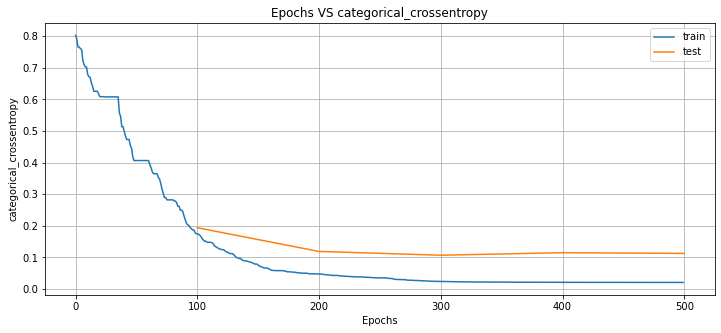

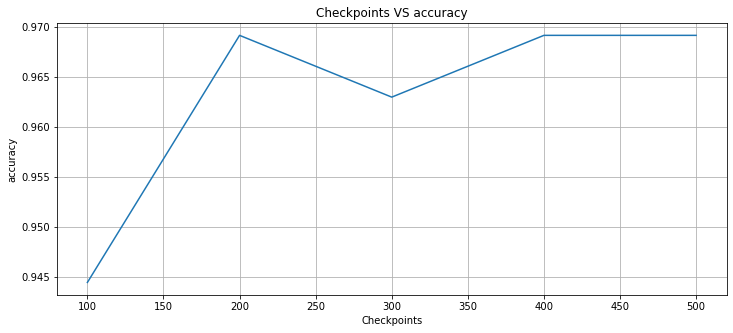

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9444444444444444, 'mean_square_error': 0.10715596715290827, 'categorical_crossentropy': 0.19383557637532553, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 8, 'tn_hit': 24, 'fn_hit': 1}, 1: {'tp_hit': 11, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 6}, 2: {'tp_hit': 13, 'fp_hit': 1, 'tn_hit': 92, 'fn_hit': 2}}, 'checkpoint': 100} 


{'accuracy': 0.9691358024691358, 'mean_square_error': 0.06906667448802656, 'categorical_crossentropy': 0.11876266090958207, 'essential_metrics': {0: {'tp_hit': 74, 'fp_hit': 3, 'tn_hit': 29, 'fn_hit': 2}, 1: {'tp_hit': 16, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 1}, 2: {'tp_hit': 13, 'fp_hit': 2, 'tn_hit': 91, 'fn_hit': 2}}, 'checkpoint': 200} 


{'accuracy': 0.9629629629629629, 'mean_square_error': 0.07056264044526091, 'categorical_crossentropy': 0.10676155266938386, 'essential_metrics': {0: {'tp_hit': 75, 'fp_hit': 5, 'tn_hit': 27, 'fn_hit': 1}, 1: {'tp_hit': 14, 'fp_hit': 0, 'tn_hit': 91, 'fn_hit': 3}, 2: {'tp_hit': 13, 'fp_hit': 1, 'tn_hit': 92,

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[-1.7678412   3.          3.          0.6322776  -0.45204136]
 bias: -3.0

Neuron 1: weights:
[-1.0998987  3.         1.313622  -3.        -1.2317438]
 bias: 3.0

Neuron 2: weights:
[ 1.3005037  -3.         -1.2079012   3.          0.97957045]
 bias: -3.0

Neuron 3: weights:
[ 2.038831  -3.        -2.276619  -1.6291205  1.1147636]
 bias: 3.0

$
Layer 2
Neuron 0: weights:
[-3.  3. -3.  3.]
 bias: 3.0

Neuron 1: weights:
[ 3.         1.9128621 -1.5648413 -3.       ]
 bias: 3.0

Neuron 2: weights:
[-3. -3.  3.  3.]
 bias: 1.5962222814559937

$

